# Classification based on embeddings

In [1]:
from datasets import load_dataset

train = load_dataset("Eathus/github-issues-vul-detection-cwe", split="train")
test = load_dataset("Eathus/github-issues-vul-detection-cwe", split="test")

train_df = train.to_pandas()
test_df = test.to_pandas()

In [5]:
import pandas as pd
cwe_counts = train_df["cve_primary_cwe"].value_counts()
cwe_num_dict = pd.Series(range(0, len(cwe_counts)), index=cwe_counts.index).to_dict()
train_df["cwe_label"] = train_df["cve_primary_cwe"].map(lambda x : int(cwe_num_dict[x]))
test_df["cwe_label"] = test_df["cve_primary_cwe"].map(lambda x : int(cwe_num_dict[x]))

## Train classification XGBoost and tuning

In [6]:
from sklearn.model_selection import train_test_split
import xgboost as xgb
import numpy as np

train_df, val_df = train_test_split(
    train_df, test_size=0.3, random_state=99, stratify=train_df["cwe_label"]
)

X_train, y_train = train_df["issue_embedding"].values, train_df["cwe_label"].values
X_val, y_val, issue_or_val = (
    val_df["issue_embedding"].values,
    val_df["cwe_label"].values,
    val_df["issue_owner_repo"],
)

data = []
for i in X_train:
    data.append(i)
X_train = np.array(data)

model = xgb.XGBClassifier(
    use_label_encoder=True, eval_metric="logloss", scale_pos_weight=250
)

# Train the classifier
model.fit(X_train, y_train)

/home/edvinn/KTH/DA231X-ex/mthesis_pyenv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [14:20:53] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "scale_pos_weight", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, objective='multi:softprob', ...)

In [ ]:
from sklearn.metrics import accuracy_score, classification_report


data = []
for i in X_val:
    data.append(i)
X_val = np.array(data)

y_pred = model.predict(X_val)

# Evaluate the model
accuracy = accuracy_score(y_val, y_pred)
report = classification_report(y_val, y_pred)

print(f"Accuracy: {accuracy}")
print("Classification Report:")
print(report)

## Testing results

In [7]:
from sklearn.metrics import accuracy_score, classification_report


X_test, y_test = test_df["issue_embedding"].values, test_df["cwe_label"].values

data = []
for i in X_test:
    data.append(i)
X_test = np.array(data)


y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print("Classification Report:")
print(report)

Accuracy: 0.8715909090909091
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.98      0.94      1456
           1       0.64      0.46      0.54        63
           2       0.57      0.35      0.44        48
           3       0.80      0.77      0.78        26
           4       0.38      0.25      0.30        24
           5       0.79      0.55      0.65        20
           6       0.67      0.21      0.32        19
           7       0.60      0.19      0.29        16
           8       0.33      0.07      0.12        14
           9       0.67      0.17      0.27        12
          10       0.67      0.44      0.53         9
          11       0.00      0.00      0.00         5
          12       0.00      0.00      0.00         6
          13       0.00      0.00      0.00         5
          14       0.50      0.50      0.50         4
          15       1.00      1.00      1.00         4
          16       0.00      

/home/edvinn/KTH/DA231X-ex/mthesis_pyenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/edvinn/KTH/DA231X-ex/mthesis_pyenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/edvinn/KTH/DA231X-ex/mthesis_pyenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

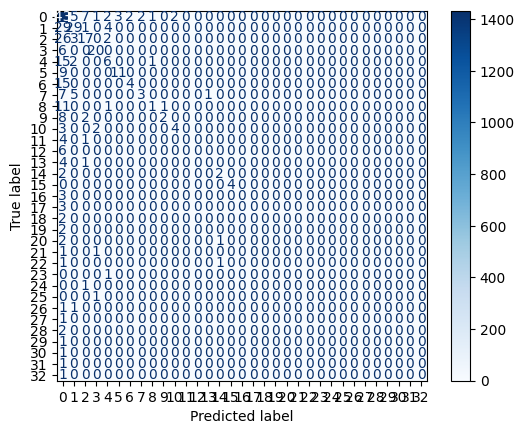

In [8]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm).plot(cmap="Blues")

In [9]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import precision_recall_curve


y_probs = model.predict_proba(X_test)[:, 1]  # Get probabilities for the positive class

# Compute ROC curve
fpr, tpr, _ = roc_curve(y_test, y_probs)

# Compute AUC
auc = roc_auc_score(y_test, y_probs)

# Compute Precision-Recall curve
precision, recall, _ = precision_recall_curve(y_test, y_probs)

# Plot ROC curve and Precision-Recall curve in the same figure
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# ROC Curve
ax1.plot(fpr, tpr, marker=".", label=f"ROC curve (AUC = {auc:.2f})")
ax1.set_xlabel("False Positive Rate")
ax1.set_ylabel("True Positive Rate")
ax1.set_title("ROC Curve")
ax1.legend()
ax1.grid(True)

# Precision-Recall Curve
ax2.plot(recall, precision, marker=".", label="Precision-Recall curve")
ax2.set_xlabel("Recall")
ax2.set_ylabel("Precision")
ax2.set_title("Precision-Recall Curve")
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

ValueError: multiclass format is not supported

In [10]:
test_df["xgb_prediction"] = y_pred

In [11]:
from datasets import Dataset

# test
ds = Dataset.from_pandas(test_df)
ds.push_to_hub("Eathus/github-issues-vul-detection-xgb-results-cwe", split="test")

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/2 [00:00<?, ?ba/s]

CommitInfo(commit_url='https://huggingface.co/datasets/Eathus/github-issues-vul-detection-xgb-results-cwe/commit/b3152c46d3407ddd3e22e12a7354052c121bd557', commit_message='Upload dataset', commit_description='', oid='b3152c46d3407ddd3e22e12a7354052c121bd557', pr_url=None, repo_url=RepoUrl('https://huggingface.co/datasets/Eathus/github-issues-vul-detection-xgb-results-cwe', endpoint='https://huggingface.co', repo_type='dataset', repo_id='Eathus/github-issues-vul-detection-xgb-results-cwe'), pr_revision=None, pr_num=None)